# Clasificador de confinamiento

In [15]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from sklearn import utils
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
plt.style.use('seaborn-bright')
from sklearn.metrics import mean_squared_error as mse
import pickle

In [2]:
#Carga de df 
df = pd.read_csv('serie_temporal_interpolada.csv', sep = ',',header=0, parse_dates=[0], index_col=0, squeeze=True)

## Balanceo de dataset

Comprobamos cantidad de datos por etiqueta.

In [3]:
df_c_A = df[df['conf_lvl']==0].shape[0]
df_c_B = df[df['conf_lvl']==1].shape[0]
df_c_C = df[df['conf_lvl']==2].shape[0]
df_c_D = df[df['conf_lvl']==3].shape[0]
df_c_E = df[df['conf_lvl']==4].shape[0]
df_c_F = df[df['conf_lvl']==5].shape[0]
df_c_G = df[df['conf_lvl']==6].shape[0]
df_c = df.shape[0]


In [466]:
df_c_E

192

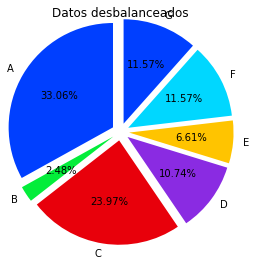

In [4]:
#Grafico
labels = ['A','B','C','D','E','F','G']
values = [df_c_A/df_c,df_c_B/df_c,df_c_C/df_c,df_c_D/df_c,df_c_E/df_c,df_c_F/df_c,df_c_G/df_c]
plt.pie(values,labels=labels,startangle=90,radius=1.2,autopct='%1.2f%%',explode =(0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Datos desbalanceados')
plt.show()

Se crea un nuevo dataset:

- Fase B eliminada (pocos datos)
- Resto de datasets se reduce a la cantidad de datos existentes en la Fase D (por ser el porcentaje minimo dentro de una cantidad aceptable de datos)

In [468]:
#Cantidad de datos en D
df_c_E

192

In [5]:

df_A = df[df['conf_lvl']==0]
df_C = df[df['conf_lvl']==2]
df_D = df[df['conf_lvl']==3]
df_E = df[df['conf_lvl']==4]
df_F = df[df['conf_lvl']==5]
df_G = df[df['conf_lvl']==6]

In [6]:
df_A_b = df_A.head(192)
df_C_b = df_C.head(192)
df_D_b = df_D.head(192)
df_E_b = df_E.head(192)
df_F_b = df_F.head(192)
df_G_b = df_G.tail(192)

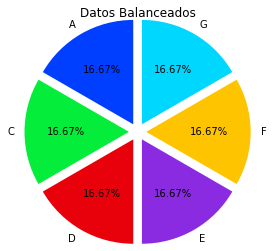

In [7]:
df_c_b = df_A_b.shape[0]+df_C_b.shape[0] +df_D_b.shape[0] +df_E_b.shape[0] +df_F_b.shape[0] +df_G_b.shape[0] 
labels = ['A','C','D','E','F','G']
values = [(df_A_b.shape[0]/df_c_b),(df_C_b.shape[0]/df_c_b),(df_D_b.shape[0]/df_c_b),(df_E_b.shape[0]/df_c_b),(df_F_b.shape[0]/df_c_b),(df_G_b.shape[0]/df_c_b)]
plt.pie(values,labels=labels,startangle=90,radius=1.2,autopct='%1.2f%%',explode =(0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Datos Balanceados')
plt.show()

In [8]:
trainset=pd.concat([df_A_b,df_C_b,df_D_b,df_E_b,df_F_b,df_G_b])

## Selección de features

Se eliminan los features year, month, day

In [473]:
trainset.shape

(1152, 12)

In [9]:
def avg(list):
    return sum(list)/len(list)

In [10]:
train_features  = pd.DataFrame(columns=['week_day','intensity_1','intensity_2','intensity_3','intensity_4','velocity_1','velocity_2','velocity_3','velocity_4','no2_lvl_1','no2_lvl_2','no2_lvl_3','no2_lvl_4','precipitation_1','precipitation_2','precipitation_3','precipitation_4','temperatura_1','temperatura_2','temperatura_3','temperatura_4','conf_lvl'])

In [11]:
i=0
j=0
intensity = []
velocity = []
no2_lvl =[]
precipitation = []
temperatura =[]

fulli=[]
fullv=[]
fulln=[]
fullp =[]
fullt=[]

for index,row in trainset.iterrows():
    
    intensity.append(row['intensity'])
    velocity.append(row['velocity'])
    no2_lvl.append(row['no2_lvl'])
    precipitation.append(row['precipitation'])
    temperatura.append(row['temperatura'])

    if i == 5:
        fulli.append(avg(intensity))
        fullv.append(avg(velocity))
        fulln.append(avg(no2_lvl))
        fullp.append(avg(precipitation))
        fullt.append(avg(temperatura))
        intensity = []
        velocity = []
        no2_lvl =[]
        precipitation = []
        temperatura =[]
        i=-1
    if j==23:
        val={'week_day':index.weekday()
             ,'intensity_1':fulli[0],'intensity_2':fulli[1],'intensity_3':fulli[2],'intensity_4':fulli[3]
            ,'velocity_1':fullv[0],'velocity_2':fullv[1],'velocity_3':fullv[2],'velocity_4':fullv[3]
            ,'no2_lvl_1':fulln[0],'no2_lvl_2':fulln[1],'no2_lvl_3':fulln[2],'no2_lvl_4':fulln[3]
            ,'precipitation_1':fullp[0],'precipitation_2':fullp[1],'precipitation_3':fullp[2],'precipitation_4':fullp[3]
            ,'temperatura_1':fullt[0],'temperatura_2':fullt[1],'temperatura_3':fullt[2],'temperatura_4':fullt[3],
            'conf_lvl':row['conf_lvl']}
        fulli=[]
        fullv=[]
        fulln=[]
        fullp =[]
        fullt=[]
        train_features = train_features.append(val,ignore_index=True )
        j=-1
    i=i+1
    j=j+1

In [214]:
train_features

,week_day,intensity_1,intensity_2,intensity_3,intensity_4,velocity_1,velocity_2,velocity_3,velocity_4,no2_lvl_1,...,no2_lvl_4,precipitation_1,precipitation_2,precipitation_3,precipitation_4,temperatura_1,temperatura_2,temperatura_3,temperatura_4,conf_lvl
0,5.0,819.375000,1853.500000,3334.625000,3200.750000,80.041667,79.833333,76.500000,73.166667,16.833333,...,32.000000,0.166667,0.000000,0.000000,0.000000,8.550000,9.300000,13.883333,9.625000,0.0
1,6.0,901.625000,1259.791667,3124.666667,2691.375000,79.541667,81.333333,78.541667,77.708333,25.055556,...,59.000000,0.000000,0.000000,0.000000,0.000000,8.291667,8.633333,9.633333,9.391667,0.0
2,0.0,351.416667,3117.916667,4356.375000,2711.541667,81.875000,63.791667,66.916667,58.458333,24.444444,...,73.388889,0.000000,0.000000,0.000000,0.000000,7.025000,5.900000,15.533333,10.633333,0.0
3,1.0,331.000000,3260.375000,4182.875000,2448.875000,80.875000,64.958333,65.875000,57.291667,40.944444,...,54.222222,0.000000,0.000000,0.000000,0.000000,6.366667,6.700000,15.683333,10.250000,0.0
4,2.0,363.208333,3393.208333,4478.875000,2737.375000,79.458333,67.222222,62.291667,56.875000,21.722222,...,78.500000,0.000000,0.000000,0.000000,0.000000,5.116667,4.000000,11.666667,7.841667,0.0
5,3.0,393.416667,3212.166667,4236.458333,3126.916667,79.833333,67.166667,59.000000,54.916667,38.000000,...,77.333333,0.000000,0.000000,0.000000,0.000000,3.741667,3.150000,7.666667,6.966667,0.0
6,4.0,512.791667,3292.333333,2981.583333,3470.166667,81.500000,64.000000,42.125000,72.541667,41.388889,...,58.222222,0.000000,0.000000,0.000000,0.000000,4.450000,4.716667,9.450000,7.425000,0.0
7,5.0,829.625000,1857.041667,3299.666667,2939.958333,81.000000,80.083333,77.041667,75.875000,56.333333,...,39.277778,0.000000,0.000000,0.000000,0.000000,4.458333,4.666667,7.850000,6.150000,0.0
8,6.0,125.000000,463.000000,798.333333,582.196970,61.527778,82.091667,83.916667,80.364899,9.222222,...,16.055556,0.166667,0.000000,0.000000,0.500000,9.641667,9.900000,15.500000,10.308333,2.0
9,0.0,110.541667,1640.208333,1949.833333,873.833333,60.125000,78.541667,77.666667,78.833333,6.277778,...,15.000000,0.833333,0.333333,0.666667,0.500000,5.041667,2.866667,4.500000,3.425000,2.0


## Modelado

In [12]:
# Load data.
train_data = train_features.to_numpy()
dataset = Bunch(
    features = train_data[:,:-1],
    target=train_data[:,-1],
    feature_names=['week_day','intensity_1','intensity_2','intensity_3','intensity_4','velocity_1','velocity_2','velocity_3','velocity_4','no2_lvl_1','no2_lvl_2','no2_lvl_3','no2_lvl_4','precipitation_1','precipitation_2','precipitation_3','precipitation_4','temperatura_1','temperatura_2','temperatura_3','temperatura_4'],
    target_names=['A','C','D','E','F','G']
    )
X,y=dataset.features,dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

In [507]:
X_test.shape

(15, 21)

In [273]:
#encode
#lab_enc = preprocessing.LabelEncoder()
#training_scores_encoded = lab_enc.fit_transform(y_train)

In [508]:
##Elegir la profundidad máxima del árbol
from sklearn.metrics import classification_report,f1_score
bescl = {'tr_f1': 0,'vl_f1':0,'d':0}
for i in range(1,15):
    m = SklearnDecisionTreeClassifier(max_depth=i)
    m.fit(X_train,y_train)
    y_pred_train = m.predict(X_train)    
    y_pred_test = m.predict(X_test)
    train_report = classification_report(y_train,y_pred_train)
    test_report = classification_report(y_test,y_pred_test)
    
    train_f1 = f1_score(y_train,y_pred_train,average='weighted')
    test_f1 = f1_score(y_test,y_pred_test,average='weighted')
    if (train_f1>=bescl['tr_f1'])and(test_f1>=bescl['vl_f1']):
        bescl = {'tr_f1': train_f1,'vl_f1':test_f1,'d':i}
        
print (bescl)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'tr_f1': 1.0, 'vl_f1': 0.7222222222222221, 'd': 10}


Buenos resultados con profundidad de 4

In [525]:
#Creamos arbol y ajustamos a los datos de entrenamiento
model = SklearnDecisionTreeClassifier(max_depth=20)
model=model.fit(X_train,y_train)
# Visualize.
export_graphviz(
    model,
    out_file="arbol_clasificador_fase.dot",
    feature_names=dataset.feature_names,
    class_names=dataset.target_names,
    rounded=True,
    filled=True,
    )
print("Done")
#predicion de salida por dataset de test
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train,y_pred_train))

Done
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         2.0       0.00      0.00      0.00         2
         3.0       0.25      0.33      0.29         3
         4.0       0.33      0.50      0.40         2
         5.0       0.50      0.50      0.50         2
         6.0       1.00      0.67      0.80         3

    accuracy                           0.53        15
   macro avg       0.51      0.50      0.50        15
weighted avg       0.56      0.53      0.54        15

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         6
         3.0       1.00      1.00      1.00         5
         4.0       1.00      1.00      1.00         6
         5.0       1.00      1.00      1.00         6
         6.0       1.00      1.00      1.00         5

    accuracy                           1.00        33
   macro avg      

## Evaluación y validación

In [510]:
#predicion de salida por dataset de test
y_pred_test=model.predict(X_test)
y_pred_train=model.predict(X_train)

In [453]:
print(classification_report(y_test,y_pred_test))
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80         2
         2.0       1.00      1.00      1.00         2
         4.0       0.80      1.00      0.89         4
         5.0       1.00      0.50      0.67         2
         6.0       1.00      0.50      0.67         2

    accuracy                           0.83        12
   macro avg       0.89      0.80      0.80        12
weighted avg       0.88      0.83      0.82        12

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         2.0       1.00      1.00      1.00         6
         4.0       1.00      1.00      1.00        12
         5.0       1.00      1.00      1.00         6
         6.0       1.00      1.00      1.00         6

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [500]:
confusion_matrix(y_test,y_pred_test)

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]], dtype=int64)

In [501]:
#formato df para facilitar el plot
y_a = pd.Series(y_test, name='Actual')
y_p  = pd.Series(y_pred_test, name='Predecida')
df_confusion = pd.crosstab(y_a, y_p, rownames=['Medida'], colnames=['Predecida'], margins=True)

In [503]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(matrix, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    plt.matshow(matrix, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(matrix.columns))
    plt.xticks(tick_marks, matrix.columns, rotation=45)
    plt.yticks(tick_marks, matrix.index)
    #plt.tight_layout()
    plt.ylabel(matrix.index.name)
    plt.xlabel(matrix.columns.name)
    # Loop over data dimensions and create text annotations.
    for i in range(6):
        for j in range(6):
            plt.text(j, i, matrix.iloc[i, j],
                     ha="center", va="center", color="b")

In [504]:
df_confusion_plot=df_confusion.drop(['All'],axis=0)
df_confusion_plot=df_confusion_plot.drop('All',axis=1)

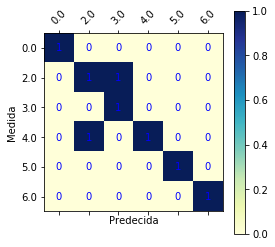

In [505]:
plot_confusion_matrix(df_confusion_plot)

In [170]:
FP = df_confusion_plot.sum(axis=0) - np.diag(df_confusion_plot)  
FN = df_confusion_plot.sum(axis=1) - np.diag(df_confusion_plot)
TP = np.diag(df_confusion_plot)
TN = df_confusion_plot.values.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)*100
# Specificity or true negative rate
TNR = TN/(TN+FP)*100 
# Precision or positive predictive value
PPV = TP/(TP+FP)*100
# Negative predictive value
NPV = TN/(TN+FN)*100
# Fall out or false positive rate
FPR = FP/(FP+TN)*100
# False negative rate
FNR = FN/(TP+FN)*100
# False discovery rate
FDR = FP/(TP+FP)*100

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)*100

print('Precisión: {}'.format(ACC))
print('Tasa de verdaderos positivos (TPR): {}'.format(TPR))
print('Tasa de verdaderos negstivos (TNR): {}'.format(TNR))
print('Tasa de falsos positivos (FPR): {}'.format(FPR))
print('Tasa de falsos negativos (FNR): {}'.format(FNR))
print('Tasa de falsos descubrimiento (FDR): {}'.format(FDR))
print('Precision o valores positivos predictivos (PPV): {}'.format(FDR))

Precisión: Predecida
0.0    100.000000
2.0     93.333333
3.0     93.333333
4.0    100.000000
5.0     86.666667
6.0     86.666667
dtype: float64
Tasa de verdaderos positivos (TPR): Medida
0.0    100.000000
2.0     50.000000
3.0    100.000000
4.0    100.000000
5.0    100.000000
6.0     33.333333
dtype: float64
Tasa de verdaderos negstivos (TNR): Predecida
0.0    100.000000
2.0    100.000000
3.0     92.307692
4.0    100.000000
5.0     84.615385
6.0    100.000000
dtype: float64
Tasa de falsos positivos (FPR): Predecida
0.0     0.000000
2.0     0.000000
3.0     7.692308
4.0     0.000000
5.0    15.384615
6.0     0.000000
dtype: float64
Tasa de falsos negativos (FNR): Medida
0.0     0.000000
2.0    50.000000
3.0     0.000000
4.0     0.000000
5.0     0.000000
6.0    66.666667
dtype: float64
Tasa de falsos descubrimiento (FDR): Predecida
0.0     0.000000
2.0     0.000000
3.0    33.333333
4.0     0.000000
5.0    50.000000
6.0     0.000000
dtype: float64
Precision o valores positivos predictivos 

## Clasificador definitivo

In [16]:
# Load data.
train_data = train_features.to_numpy()
dataset = Bunch(
    features = train_data[:,:-1],
    target=train_data[:,-1],
    feature_names=['week_day','intensity_1','intensity_2','intensity_3','intensity_4','velocity_1','velocity_2','velocity_3','velocity_4','no2_lvl_1','no2_lvl_2','no2_lvl_3','no2_lvl_4','precipitation_1','precipitation_2','precipitation_3','precipitation_4','temperatura_1','temperatura_2','temperatura_3','temperatura_4'],
    target_names=['A','C','D','E','F','G']
    )
X,y=dataset.features,dataset.target

#Creamos arbol y ajustamos a los datos de entrenamiento
cls = SklearnDecisionTreeClassifier(max_depth=20)
cls=cls.fit(X,y)

pickle.dump(cls,open('clasificador.pkl','wb'))


# Visualize.
export_graphviz(
    model,
    out_file="arbol_clasificador_fase_def.dot",
    feature_names=dataset.feature_names,
    class_names=dataset.target_names,
    rounded=True,
    filled=True,
    )